In [1]:
import logging
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA


from pynamics import downsample, downsample_split, avg_over, get_attractor_dimension
from pynamics.utils import np_cache, eigsort

from randnn import SparseRandNN, scaling_analysis
from hoogland_masters.plotting import *


rc('text', usetex=True)
logging.basicConfig(level=logging.INFO)

In [2]:
# Shared parameters
N_NEURONS = 500
TIMESTEP = 0.1
N_STEPS = 100000
N_BURNIN_STEPS = 500
DOWNSAMPLE_RATE = 100

$$\tau \frac{dh_i}{dt}=-h_i+\sum_{j=1}^N J_{ij}\phi(h_j),$$

- $g$ is the coupling strength
- $N$ is the number of neurons
- $k_\text{dense} = N-1$ is the degree of the dense network (no self-connections)
- $S$ is the sparsity coefficient:
    - $\bar k_\text{sparse}=(N-1)\cdot (1-S)$ is the degree of the sparse network.


#### How to compare sparse networks to dense networks?
1. Constant $g$ and $N$: This is the naive option. The problem is that the average neuron will see have less input. Just like a network with a lower $g$  
2. Constant $N$: Vary $g:\quad g\cdot k_\text{dense} = g'\cdot \bar k_\text{sparse}$: Here the problem is that $\phi$ is non-linear, so although the "average connective strength" is constant, the dynamic rule is changed. This might work better with threshold units (esp. linear ones)
3. Constant $g$: Vary $N: N = N'\cdot(1-S)$: The average connection strength is the same per node & we're in the same range for $\phi$, but the network is of a different size.  


Option 2 seems best (though I'll try all of the above). It's the same idea that Engelken et al. use to compare networks of different sizes.

In [3]:

def plot_curves_with_sparsity(
    g: int,
        sparsities: Sequence,
        observable: Callable[[np.ndarray, ContinuousNN], np.ndarray],
        dim_observable: Optional[int]=None,
        n_dofs: int = 100,
        n_steps: int = 10000,
        n_burn_in: int = 1000,
        t_ons: int = 10,
        normalize: bool = False,
    **kwargs
):
    """
    A helper function for plotting vector measurements across ranges of
    coupling strength values. Each measurement will be plotted as a single curve.

    :param gs: The list of coupling strengths at which to measure sample trajectories.
    :param observable: A function which takes a generated trajectory and
        the Trajectory object that generated it, and computes a
        measurement on it.
    :param dim_observable: The dimensionality of the returned observable. Defaults to ``n_dofs``
    :param n_dofs: The number of elements (neurons).
    :param timestep: The discretization timestep.
    :param n_steps: How many timesteps to simulate for each
        coupling_strength.
    :param n_burn_in: How many burnin timesteps to simulate before
        starting to record.
    :param normalize: Whether or not to divide the measurement result
        by n_dofs.
    :param network_seed: The random seed to use when drawing coupling
        matrices.  Setting this ensures that the networks at different
        sizes differ only in the coupling strength and not in the
        normalized network topologies.  This lets us compare similar
        networks.
    """
    if dim_observable is None:
        dim_observable = n_dofs

    measurement = np.zeros(dim_observable)

    for i, s in enumerate(sparsities):
        # 1. Initialize a network
        cont_nn = SparseRandNN(coupling_strength=g,
                               sparsity=s,
                               n_dofs=n_dofs,
                               **kwargs)

        # 2. Simulate a phase space trajectory
        trajectory = cont_nn.run(n_steps=n_steps, n_burn_in=n_burn_in)

        # 3. Perform your measurement
        measurement = observable(trajectory, cont_nn)

        # (4.) Potentially normalize
        if normalize:
            measurement = measurement / n_dofs

        plt.plot(measurement, label=f"s={s}")

    plt.legend()
    plt.show()


Generating samples: 100%|██████████| 50000/50000 [00:17<00:00, 2797.77it/s]
INFO:root:Saving to ./saves/trajectories/trajectory-2276ba201b3d0ed5b6f76817cf121432.npy
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 500it [00:02, 193.33it/s]
INFO:root:Saving to ./saves/lyapunov/spectrum-6bf29224efac42ebcde5faf0f34aaa7f.npy
Generating samples: 100%|██████████| 50000/50000 [00:19<00:00, 2538.80it/s]
INFO:root:Saving to ./saves/trajectories/trajectory-3c6e650e7ca4cede512d3b3be0aa7e37.npy
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 500it [00:02, 178.62it/s]
INFO:root:Saving to ./saves/lyapunov/spectrum-8a99b71328b5d123b1248c34f9214c72.npy
Generating samples: 100%|██████████| 50000/50000 [00:20<00:00, 2464.18it/s]
INFO:root:Saving to ./saves/trajectories/trajectory-f43b8bf80beab767696120627832eb2f.npy
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 500it [00:02, 218.69it/s]
INFO:root:Saving to .

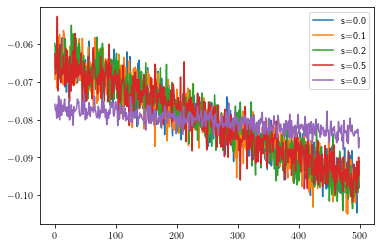

In [4]:
SPARSITIES = [0., 0.1, 0.2, 0.5, 0.9]

def get_lyapunov_spectrum(trajectory, system):
    return np.sort(system.get_lyapunov_spectrum(trajectory[::DOWNSAMPLE_RATE], t_ons=100))[::-1]

plot_curves_with_sparsity(1.5, SPARSITIES, get_lyapunov_spectrum, n_dofs=500, n_steps=50000)

INFO:root:Loading from save ./saves/trajectories/trajectory-2276ba201b3d0ed5b6f76817cf121432.npy
INFO:root:Loading from save ./saves/lyapunov/spectrum-6bf29224efac42ebcde5faf0f34aaa7f.npy
INFO:root:Loading from save ./saves/trajectories/trajectory-3c6e650e7ca4cede512d3b3be0aa7e37.npy
INFO:root:Loading from save ./saves/lyapunov/spectrum-8a99b71328b5d123b1248c34f9214c72.npy
INFO:root:Loading from save ./saves/trajectories/trajectory-f43b8bf80beab767696120627832eb2f.npy
INFO:root:Loading from save ./saves/lyapunov/spectrum-9b3b65ddb37f356e9ab734a92e674888.npy
INFO:root:Loading from save ./saves/trajectories/trajectory-2a9ef60fb9557fe00c8494a08b88d444.npy
INFO:root:Loading from save ./saves/lyapunov/spectrum-5a97790bb5c990fd8608c2647b586929.npy
Generating samples: 100%|██████████| 50000/50000 [00:18<00:00, 2708.89it/s]
INFO:root:Saving to ./saves/trajectories/trajectory-667ee82bf9c04ea5e5b7bedcf953978f.npy
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 500

KeyboardInterrupt: 

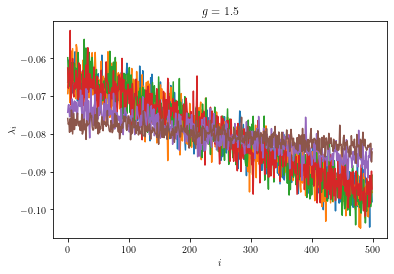

In [5]:
SPARSITIES = [0., 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99]
GS = [1.5, 2., 3., 5., 10., 20.]

for g in GS:
    plt.title(f"$g={g}$")
    plt.ylabel("$\lambda_i$")
    plt.xlabel("$i$")
    plot_curves_with_sparsity(g, SPARSITIES, get_lyapunov_spectrum, n_dofs=500, n_steps=50000)

In [ ]:
rc('text', usetex=False)

def get_lyapunov_spectrum(trajectory, system):
    n_dofs = trajectory.shape[1]
    return np.arange(n_dofs)/n_dofs, np.sort(system.get_lyapunov_spectrum(trajectory[::DOWNSAMPLE_RATE], t_ons=100))[::-1]

def plot_curves_with_param_range(
        param_range: List[dict],
        observable: Callable[[np.ndarray, ContinuousNN], np.ndarray],
        n_steps: int = 10000,
        n_burn_in: int = 1000,
    **kwargs
):
    """
    A helper function for plotting vector measurements across ranges of
    coupling strength values. Each measurement will be plotted as a single curve.
:param observable: A function which takes a generated trajectory and
        the Trajectory object that generated it, and computes a
        measurement on it.
    :param n_dofs: The number of elements (neurons).
    :param n_steps: How many timesteps to simulate for each
        coupling_strength.
    :param n_burn_in: How many burnin timesteps to simulate before
        starting to record.
    :param kwargs:
    """
    for i, params in enumerate(param_range):
        # 1. Initialize a network
        cont_nn = SparseRandNN(**params,
                               **kwargs)

        # 2. Simulate a phase space trajectory
        trajectory = cont_nn.run(n_steps=n_steps, n_burn_in=n_burn_in)

        # 3. Perform your measurement
        measurement_range, measurement = observable(trajectory, cont_nn)

        label = ", ".join(list(map(lambda vals: f"{vals[0]} {vals[1]}", params.items())))
        plt.plot(measurement_range, measurement, label=f"{i}. {label}")

    plt.legend()


In [ ]:
SPARSITIES = [0., 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99]
SPARSITIES_RANGE = map(lambda s: {"sparsity": s}, SPARSITIES)
GS = [1.5, 2., 3., 5., 10., 20.]

for g in GS:
    plt.title(f"$g={g}$")
    plt.ylabel("$\lambda_i$")
    plt.xlabel("$i$")
    plot_curves_with_param_range(SPARSITIES_RANGE, get_lyapunov_spectrum, n_dofs=500, n_steps=50000, coupling_strength=g, normalize_strength=True)
    plt.show()


In [ ]:
SPARSITIES = [0., 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]
SPARSITIES_RANGE = map(lambda s: {"sparsity": s, "n_dofs": int(1 + (99/(1-s)))}, SPARSITIES)
GS = [2., 3., 5., 10., 20.]

for g in GS:
    plt.title(f"$g={g}$")
    plt.ylabel("$\lambda_i$")
    plt.xlabel("$i$")
    plot_curves_with_param_range(SPARSITIES_RANGE, get_lyapunov_spectrum, n_steps=50000)